In [1]:
# pyrates imports
from pyrates.utility import plot_timeseries, grid_search, plot_psd, plot_connectivity, create_cmap

# additional imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 28
mpl.rcParams['ytick.labelsize'] = 28
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['legend.fontsize'] = 20

%matplotlib inline

PyRates Jansen-Rit Model Simulations
====================================

Below, you will find the code to run the Jansen-Rit model simulations described in detail in "Gast, R. et al. (2018) PyRates - A Python framework for neural modeling and simulations on parallel hardware". These simulations test the correct dynamic behavior of a single Jansen-Rit model for a number of different model parametrizations. The Jansen-Rit model is a simple 3-population neural mass model, initially proposed by Jansen and Rit in 1995: "Jansen & Rit (1195) ....". The PyRates model implementation can be found under templates/jansenrit.

Simulation 1: Jansen-Rit model sensitivity to changes in the global coupling strength
--------------------------------------------------------------------------------------

In the following cells, we examine the relationship between changes in the global coupling strength c and the dynamic behavior of the Jansen-Rit model. Thereby, c scales the connections between the 3 populations of the Jansen-Rit model (pyramidal cells, excitatory interneurons, inhibitory interneurons). The dynamic behavior of the Jansen-Rit model is operationalized via the average membrane potential time traces of the pyramidal cells. Model parameters and simulation configuration follow Jansen & Rit (1995). 

1) Parameter definition:  In the following cell, the different conditions and basic simulation parameters are defined.

In [2]:
dt = 1e-4                                                       # integration step-size of the forward euler solver in s
T = 3.                                                          # overall simulation time in s
C = np.array([68., 128., 135., 270., 675., 1350.])              # global connection weight scaling
inp = np.random.uniform(120., 320., (int(T/dt), 1))             # white noise input to the pyramidal cells in Hz.

params = {'c_pe': [], 'c_pi': [], 'c_ep': [], 'c_ip': []}       # connection weights that should be changed in each condition
param_map = {'c_pe': {'var': [(None, 'weight')],                # mapping between the variable names in params and the corresponding model parameters
                      'edges': [('PC.0', 'EIN.0', 0)]},
             'c_pi': {'var': [(None, 'weight')], 
                      'edges': [('PC.0', 'IIN.0', 0)]},
             'c_ep': {'var': [(None, 'weight')], 
                      'edges': [('EIN.0', 'PC.0', 0)]},
             'c_ip': {'var': [(None, 'weight')], 
                      'edges': [('IIN.0', 'PC.0', 0)]}}

for c in C:
    params['c_pe'].append(np.round(1.0 * c, decimals=2))
    params['c_pi'].append(np.round(0.25 * c, decimals=2))
    params['c_ep'].append(np.round(0.8 * c, decimals=2))
    params['c_ip'].append(np.round(0.25 * c, decimals=2))

2) In the following cell, all conditions will be evaluated in parallel using the grid_search functionality of PyRates

In [3]:
results = grid_search(circuit_template="model_templates.jansen_rit.simple_jansenrit.JRC",
                      param_grid=params, param_map=param_map,
                      inputs={("PC", "RPO_e_pc.0", "u"): inp}, outputs={"v": ("PC", "PRO.0", "PSP")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# order and rename columns
vals = [col[0] for col in results.columns.values]
idx = np.argsort(vals)
vals = np.sort(vals)
results = results.iloc[:, idx]
results.columns = [f'C = {v}' for v in vals]

ValueError: Tried to convert 'input' to a tensor and failed. Error: None values not supported.

3) Results visualization: For each condition, the time-series of the pyramidal cell's membrane potential will be plotted

/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['time'] = data.index


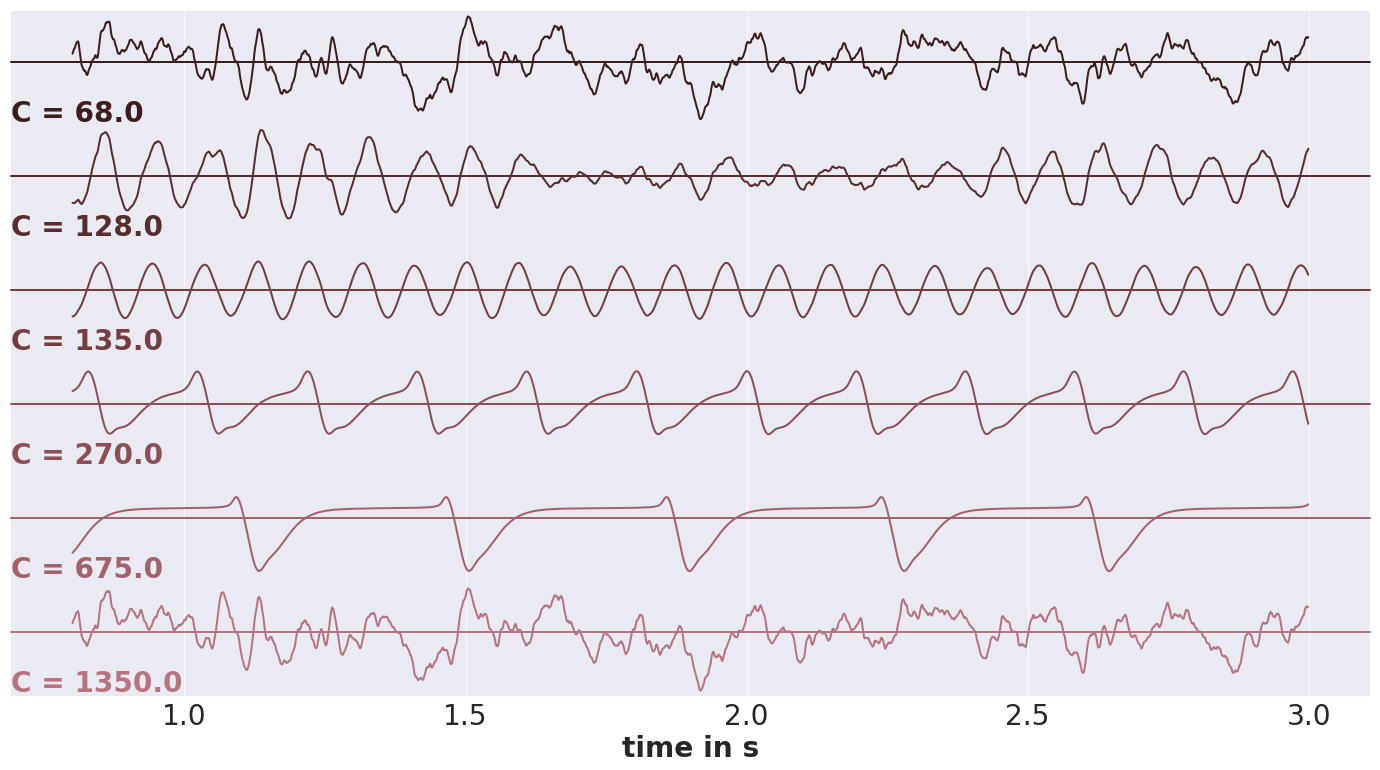

In [105]:
cm_red = create_cmap('pyrates_green', as_cmap=False, n=16, reverse=True)
plot_timeseries(results.iloc[results.index > 0.8, :], plot_style='ridge_plot', demean=True, hspace=-.01,
                fontsize=28, aspect=10, height=2.0, cmap=cm_red)
fig, ax = plt.gcf(), plt.gca()
plt.gcf().ax[0].set_title('Pyramidal cell average membrane potential in V', pad=20.)
fig.set_size_inches(16., 11.)
ax.set_xlabel('time in s')
#plt.savefig('/img/Gast_2018_PyRates_JansenRit_C.svg', format='svg')

Simulation 2: Jansen-Rit model sensitivity to changes in the synaptic timescales
---------------------------------------------------------------------------------

In the following cells, we examine the relationship between changes in the synaptic timescales and the dynamic behavior of the Jansen-Rit model. Thereby, we systematically change the excitatory and inhibitory synaptic timescales and evaluate dynamic behavior of the Jansen-Rit model for each combination of the two. The dynamic behavior is operationalized as the response frequency band with the highest power-spectral density evaluated via the membrane potential itime traces of the pyramidal cell population. 

1) Parameter definition:  In the following cell, the different conditions and basic simulation parameters are defined.

In [59]:
# parameter definition
dt = 5e-5                                                                       # integration step-size in s
T = 10.                                                                         # simulation time in s
tau_e = np.arange(1e-3, 63e-3, 3e-3)                                            # excitatory synaptic timescales
tau_i = np.arange(1e-3, 63e-3, 3e-3)[::-1]                                      # inhibitory synaptuic timescales
inp = 220. + np.random.randn(int(T/dt), 1) * 22.                                # white noise input delivered to the pyramidal cells
params = {'tau_e': [], 'tau_i': [], 'H_e': [], 'H_i': []}                       # synaptic timescales tau and efficacies H
for t_e in tau_e:
    for t_i in tau_i:
        params['tau_e'].append(t_e)                               
        params['tau_i'].append(t_i)
        params['H_e'].append(3.25e-3*10e-3/t_e)                                
        params['H_i'].append(-22e-3*20e-3/t_i)

param_map = {'tau_e': {'var': [('RPO_e_pc.0', 'tau'), ('RPO_e.0', 'tau')], 
                       'nodes': ['PC.0', 'EIN.0', 'IIN.0']},
             'tau_i': {'var': [('RPO_i.0', 'tau')], 
                       'nodes': ['PC.0']},
             'H_e': {'var': [('RPO_e_pc.0', 'h'), ('RPO_e.0', 'h')], 
                     'nodes': ['PC.0', 'EIN.0', 'IIN.0']},
             'H_i': {'var': [('RPO_i.0', 'h')], 
                     'nodes': ['PC.0']}}

2) In the following cell, all conditions will be evaluated in parallel using the grid_search functionality of PyRates

In [60]:
results = grid_search(circuit_template="pyrates.examples.jansen_rit.simple_jr.JRC",
                      param_grid=params, param_map=param_map,
                      inputs={("PC", "RPO_e_pc.0", "u"): inp}, outputs={"v": ("PC", "PRO.0", "PSP")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 8.78056788444519 seconds.


3) 

In [61]:
# calculate PSDs
cut_off = 1.
max_freq = np.zeros((len(tau_i), len(tau_e)))
freq_pow = np.zeros_like(max_freq)
for t_e, t_i, h_e, h_i in zip(params['tau_e'], params['tau_i'], params['H_e'], params['H_i']):       # loop over conditions
    if not results[t_e][t_i][h_e][h_i].isnull().any().any():
        _ = plot_psd(results[t_e][t_i][h_e][h_i], tmin=cut_off, show=False)                          # calculate the psd for the condition
        power = plt.gca().get_lines()[-1].get_ydata()                                                # extract powers
        freqs = plt.gca().get_lines()[-1].get_xdata()                                                # extract frequencies
        idx_c, idx_r = np.argwhere(tau_e == t_e)[0], np.argwhere(tau_i == t_i)[0]
        p = np.max(power)                                                                            
        f = freqs[np.argmax(power)]                                                                  # remember frequency with highest power
        if p < 70.:
            if f < 4.:
                max_freq[idx_r, idx_c] = 1.
            elif f < 8.:
                max_freq[idx_r, idx_c] = 2.
            elif f < 12.:
                max_freq[idx_r, idx_c] = 3.
            elif f < 30.:
                max_freq[idx_r, idx_c] = 4.
            else:
                max_freq[idx_r, idx_c] = 5.
        else:
            max_freq[idx_r, idx_c] = 0.
        freq_pow[idx_r, idx_c] = p 
        plt.close('all')

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data,

4) 

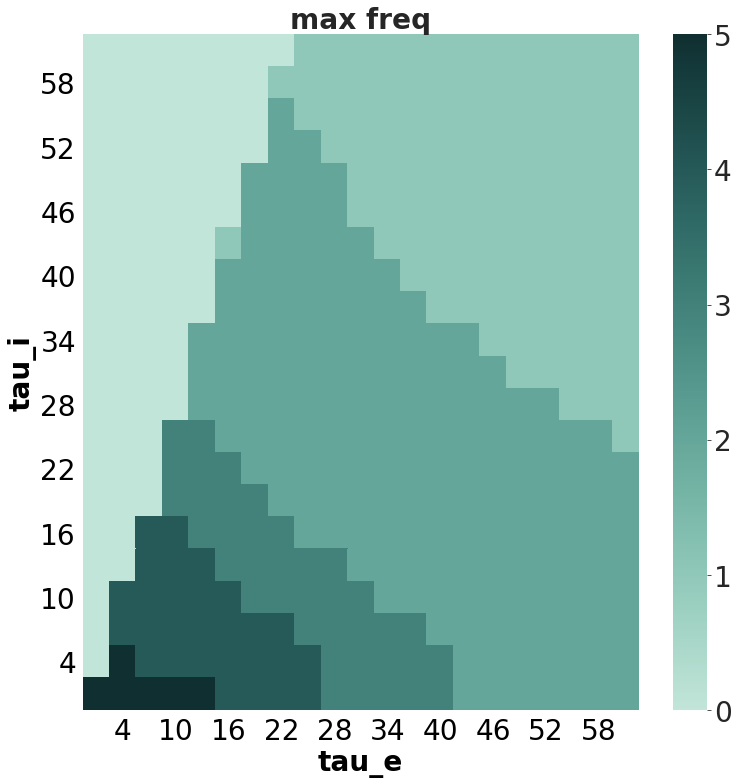

In [ ]:
# create axis ticks
yticks = (tau_i * 1e3).astype('int')
yticks[::2] = 0.
yticks = [str(y) if y > 0. else '' for y in yticks]
xticks = (tau_e * 1e3).astype('int')
xticks[::2] = 0.
xticks = [str(x) if x > 0. else '' for x in xticks]

# create a color map
cm_red = create_cmap('pyrates_red', as_cmap=True)

# plot the dominant frequencies
fig, ax = plt.subplots(figsize=(11, 11))
ax = plot_connectivity(max_freq, ax=ax, yticklabels=list(yticks), xticklabels=list(xticks), cmap=cm_red)

# adjust labels
ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')
ax.set_xlabel(r'$\mathbf{\tau_e}$ in ms', labelpad=15.)
ax.set_ylabel(r'$\mathbf{tau_i}$ in ms', labelpad=15.)
ax.set_title(f'Dominant frequency band', pad=20.)
cbar = plt.gcf().axes[-1]
cbar.set_yticklabels(['hyper signal', 'r$\delta$ (1-4 Hz.)', r'$\theta$ (4-8 Hz.)', r'$\alpha$ (8-12) Hz.', 
                      r'$\beta$ (12-30) Hz.', r'$\gamma$ (> 30 Hz.)'])

plt.tight_layout()
#plt.savefig('/img/Gast_2018_PyRates_JansenRit_taus.svg', format='svg')